In [308]:
import sys
sys.path.append('..')

import os
import pickle
from glob import glob
import argparse
from multiprocessing import Pool

import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib import font_manager
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick

from tqdm import tqdm

from units import *
from cdisk_analysis import *

In [309]:
par_pickle_filename = '../cdi.par.pickle'
with open(par_pickle_filename, 'rb') as f:
    parameters = pickle.load(f)

prepath = str(os.path.expanduser('~'))
data_folder = prepath+'/landing/data'
run_folder = os.path.join(data_folder,'pds70c')

print('Plotting run folder -> {}'.format(run_folder))

n_frames = len(glob(os.path.join(run_folder,'gasdens*.dat')))-1
data_files = [os.path.join(run_folder, 'gasdens{}.dat') for i in range(n_frames)]

host_star_data_path = os.path.join(run_folder,'planet0.dat')
satellite_data_path = os.path.join(run_folder,'planet1.dat')
orbit_data_path = os.path.join(run_folder,'orbit0.dat')

host_star, host_star_orbit = read_planet_orbit_data(host_star_data_path, orbit_data_path)
if os.path.exists(satellite_data_path):
    satellite, satellite_orbit = read_planet_orbit_data(satellite_data_path, orbit_data_path)
else:
    satellite = None

plot_params=[]
print('Loading in {} data frames...'.format(n_frames))
for i in tqdm(range(len(data_files))):

    data_filename = 'gasdens{}.dat'.format(i)
    data_path = os.path.join(run_folder, data_filename)
    phi, r, density = read_fargo_data(data_path, parameters)

    if satellite is not None:
        plot_params.append((i, r, phi, density, parameters, (host_star['x'][i], host_star['y'][i]), (satellite['x'][i], satellite['y'][i])))
    else:
        plot_params.append((i, r, phi, density, parameters, (host_star['x'][i], host_star['y'][i]), None))

Plotting run folder -> /Users/jsn/landing/data/pds70c
Loading in 26669 data frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26669/26669 [00:13<00:00, 1924.75it/s]


In [346]:
disk_mass = np.zeros(len(plot_params))
for i,params in enumerate(plot_params):
    r = params[1]
    phi = params[2]
    density = params[3]

    diff = r[1:] - r[:-1]
    dx = (2*np.pi/parameters['Nx'])*diff
    mass = np.sum(density.T * diff*dx)
    disk_mass[i] = mass

disk_mass = np.array(disk_mass)

dt = parameters['DT']
times = dt * np.arange(0, len(data_files), 1)

scaled_times = times * sec_to_yr
scaled_disk_mass = disk_mass * g_to_MJ

In [354]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=('#6699CC', '#004488', '#EECC66', '#994455', '#997700', '#EE99AA', '#000000'))

/var/folders/6y/p7j56dj17hj87w_r01qjgv480000gn/T/ipykernel_2662/879205587.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


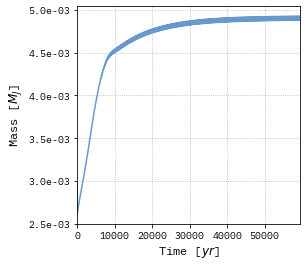

In [382]:
font_path =  '../IBMPlexMono-Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()

fig,ax = plt.subplots(figsize=(4,4))
ax.plot(scaled_times, scaled_disk_mass, label='PDS 70c')

ax.set_xlim(0,np.max(scaled_times))

ax.set_xticks(np.linspace(0,50000,6))
ax.set_yticks(np.linspace(0.00250,0.0050,6))

ax.set_xlabel('Time [$yr$]', fontsize=12)
ax.set_ylabel('Mass [$M_J$]', fontsize=12)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.grid(linestyle=':')

fig.show()
fig.savefig('../plots/disk_mass.jpg', bbox_inches='tight')